In [1]:
%matplotlib inline
#from utils import *
from os.path import join
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from time import time
import matplotlib.cm as cm

from sklearn.metrics import silhouette_samples, silhouette_score
import umap

In [2]:
data_root = 'drumData'
n_fft = 1024
hop_length = n_fft/4
use_logamp = False # boost the brightness of quiet sounds
reduce_rows = 10 # how many frequency bands to average into one
reduce_cols = 1 # how many time steps to average into one
crop_rows = 32 # limit how many frequency bands to use
crop_cols = 32 # limit how many time steps to use
limit = None # set this to 100 to only process 100 samples

drumNames = ["kick", "tom", "snare", "clap", "hi.hat", "ride", "crash"]
drumFingerPrints = {}
drumSamples = {}
for d in drumNames:
    %time drumSamples[d] = np.load(join(data_root, d+'_samples.npy'))

CPU times: user 1.02 ms, sys: 176 ms, total: 177 ms
Wall time: 487 ms
CPU times: user 563 µs, sys: 14.1 ms, total: 14.7 ms
Wall time: 41.8 ms
CPU times: user 1.15 ms, sys: 88.1 ms, total: 89.2 ms
Wall time: 239 ms
CPU times: user 634 µs, sys: 44.7 ms, total: 45.3 ms
Wall time: 126 ms
CPU times: user 510 µs, sys: 5.61 ms, total: 6.12 ms
Wall time: 16.8 ms
CPU times: user 507 µs, sys: 7.45 ms, total: 7.96 ms
Wall time: 23.2 ms
CPU times: user 1.1 ms, sys: 26.8 ms, total: 27.9 ms
Wall time: 69.3 ms


# Load 6x24 MIR features

In [3]:
x_data_MIR = []
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_MIRfeatures.npy'
    drum_features = np.load(file_path)
    print(drum_features.shape)
    x_data_MIR.extend(drum_features)
x_data_MIR = np.asarray(x_data_MIR)
print("x_data_MIR.shape:", x_data_MIR.shape)
x_data_MIR = x_data_MIR.reshape(len(x_data_MIR),-1)
print("x_data_MIR.shape:", x_data_MIR.shape)

(5158, 6, 24)
(422, 6, 24)
(2546, 6, 24)
(1324, 6, 24)
(159, 6, 24)
(228, 6, 24)
(723, 6, 24)
('x_data_MIR.shape:', (10560, 6, 24))
('x_data_MIR.shape:', (10560, 144))


# Load 32x32 STFT features

In [4]:
import pickle
data_root = 'drumData/'
initial_dims = [30]
perplexities = [30]
mode = 'fingerprints'
drumNames = pickle.load(open(data_root+'drumNames.pickle'))
drumLengths = pickle.load(open(data_root+'drumLengths.pickle'))

drumPrints = []
drumLabels = []
for i, drum in enumerate(drumNames):
    STFT_feat = np.load(join(data_root, drum+'_fingerprints.npy'))
    drumPrints.extend(STFT_feat)
    drumLabels.extend([i] * STFT_feat.shape[0])

x_data_STFT = np.asarray(drumPrints)
print("x_data_STFT.shape:", x_data_STFT.shape)
x_data_STFT = x_data_STFT.reshape(len(x_data_STFT),-1)
print("x_data_STFT.shape:", x_data_STFT.shape)

('x_data_STFT.shape:', (10560, 32, 32))
('x_data_STFT.shape:', (10560, 1024))


# Load MFCC features

In [5]:
x_data_MFCC = []
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_MFCCs.npy'
    drum_features = np.load(file_path)
    x_data_MFCC.extend(drum_features)
x_data_MFCC = np.asarray(x_data_MFCC)
print("x_data_MFCC.shape:", x_data_MFCC.shape)
x_data_MFCC = x_data_MFCC.reshape(len(x_data_MFCC),-1)
print("x_data_MFCC.shape:", x_data_MFCC.shape)

('x_data_MFCC.shape:', (10560, 30, 24))
('x_data_MFCC.shape:', (10560, 720))


# Load Wavenet features 23x16

In [6]:
x_data_Wavenet = []
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_wavenet.npy'
    drum_features = np.load(file_path)
    x_data_Wavenet.extend(drum_features)
x_data_Wavenet = np.asarray(x_data_Wavenet)
print("x_data_Wavenet.shape:", x_data_Wavenet.shape)
x_data_Wavenet = x_data_Wavenet.reshape(len(x_data_Wavenet),-1)
print("x_data_Wavenet.shape:", x_data_Wavenet.shape)

('x_data_Wavenet.shape:', (10560, 23, 16))
('x_data_Wavenet.shape:', (10560, 368))


# Create ground truth labels

('y_data.shape:', (10560,))


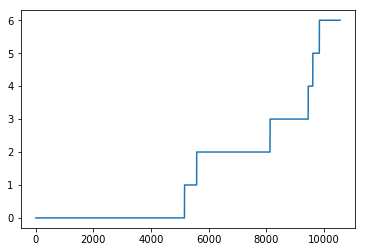

In [7]:
drumLabels = []
for i, drum in enumerate(drumNames):
    STFT_feat = np.load(join(data_root, drum+'_fingerprints.npy'))
    drumPrints.extend(STFT_feat)
    drumLabels.extend([i] * STFT_feat.shape[0])
y_data = np.asarray(drumLabels)
print("y_data.shape:", y_data.shape)
plt.figure()
plt.plot(y_data)

# Create ground truth color map

In [8]:
import itertools
def concatColors(segmentList, colorList):
    multiples = []
    #print segmentList, colorList
    for i in range(len(segmentList)):
        multiples.append([colorList[i]]*segmentList[i])
    return list(itertools.chain(*multiples))

colors = ['#000000', '#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff']
drumLengths = [5158,422,2546,1324,159,228,723]
colorMap = concatColors(drumLengths, colors)

In [28]:

from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, MultiPolygon, Point
def computeSilCoeff(data, cluster_labels):
    silhouette_avg = silhouette_score(data, cluster_labels)
    #print("The average silhouette_score is :", silhouette_avg)
    return silhouette_avg

def plotSampleSilCoeff(data, cluster_labels, title):
    fig, ax1 = plt.subplots()
    silhouette_avg = silhouette_score(data, cluster_labels)
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    
    n_clusters = 7
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    #ax1.set_title("Av. Sil Coeff:", silhouette_avg)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [25]:
def clusterGeometryMetrics(drum_points, labels):
    
    grouped_drum_points = {}
    
    for i in range(len(drum_points)):
        if labels[i] not in grouped_drum_points:
            grouped_drum_points[labels[i]] = list()
        grouped_drum_points[labels[i]].append(drum_points[i])
    
    num_labels = len(grouped_drum_points)
    drum_polygons = {}
    
    for drum in grouped_drum_points:
        points = grouped_drum_points[drum]
        hull = ConvexHull(grouped_drum_points[drum])
        drum_polygons[drum] = Polygon([points[v] for v in hull.vertices])
    
    total_hull = ConvexHull(drum_points)
    total_polygon = Polygon([drum_points[v] for v in total_hull.vertices])
    p = [Point(c) for c in total_polygon.exterior.coords]
    total_diameter = max([p1.distance(p2) for p1 in p for p2 in p])
    
    calc_intersect = lambda i, j: drum_polygons[i].intersection(drum_polygons[j]).area / total_polygon.area
    calc_roundness = lambda poly : 4 * np.pi * poly.area / (poly.length**2)
    calc_distance = lambda i, j: drum_polygons[i].distance(drum_polygons[j]) / total_diameter
    
    #overlap areas between the polygons of the different clusters, normalized by area of total plot polygon
    pairwise_intersect_areas = [[calc_intersect(i,j) for i in range(num_labels)] for j in range(num_labels)]
    
    
    # Distance between nearest points of 2 polygons normalized by "diameter" of total plot polygon
    pairwise_distances = [[calc_distance(i,j) for i in range(num_labels)] for j in range(num_labels)]
    
    #measure of "roundness" of each polygon based on Polsby-Popper Test
    roundness = [calc_roundness(drum_polygons[d]) for d in drum_polygons]
    roundness_np = np.asarray(roundness)
    roundness_mean = np.mean(roundness_np)
    
    #relative sizes of each cluster polygon normalized by area of total plot polygon
    relative_areas = [drum_polygons[d].area / total_polygon.area for d in drum_polygons]
    
   #the polygons themselves for further processing 
    polygons = drum_polygons.values() + [total_polygon]
    
    #the area of the union of all cluser polygons over the area of the total plot
    overlap_ratio = reduce(lambda a,b: a.union(b), polygons[1:], polygons[0]).area / sum([p.area for p in polygons])
    
    returnVal = {}
    returnVal['pairwise_intersect_areas'] = pairwise_intersect_areas
    returnVal['roundness'] = roundness
    returnVal['roundness_mean'] = roundness_mean
    returnVal['relative_areas'] = relative_areas
    returnVal['overlap_ratio'] = overlap_ratio
    returnVal['polygons'] = polygons
    returnVal['pairwise_distances'] = pairwise_distances
    return returnVal

def evalMetrics(data, cluster_labels):
    silhouette_score = computeSilCoeff(data, cluster_labels)
    geometry_dict = clusterGeometryMetrics(data, cluster_labels)
    final_score = silhouette_score + geometry_dict['roundness_mean'] + geometry_dict['overlap_ratio']
    return (silhouette_score,geometry_dict['roundness_mean'],geometry_dict['overlap_ratio'],final_score)

def plot2D(reduced_data, colorMap, dim_red_type, feature):
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1],c=colorMap,s=2)
    plt.title(dim_red_type + " on " + feature)
    plt.show()

# Evaluating UMAP

In [12]:
def get_scaled_umap_embeddings(features, neighbour, distance):
    
    embedding = umap.UMAP(n_neighbors=neighbour,
                          min_dist=distance,
                          metric='correlation').fit_transform(features)
    scaler = MinMaxScaler()
    scaler.fit(embedding)
    return scaler.transform(embedding)

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale



In [22]:
import time
umap_embeddings = {}
#umap_embeddings['mfccs'] = []
#umap_embeddings['MIR'] = []
umap_embeddings['STFT'] = []
#umap_embeddings['Wavenet'] = []

neighbours = [50]
distances = [0.5]
redu_data = PCA(n_components=10).fit_transform(x_data_STFT)
for i, neighbour in enumerate(neighbours):
    for j, distance in enumerate(distances):
        start_time = time.time()
        
#         umap_mfccs = get_scaled_umap_embeddings(x_data_MFCC,
#                                                 neighbour,
#                                                 distance)
#         umap_MIR = get_scaled_umap_embeddings(x_data_MIR,
#                                                   neighbour,
#                                                   distance)
        umap_STFT = get_scaled_umap_embeddings(redu_data,
                                                  neighbour,
                                                  distance)
        
#         umap_Wavenet = get_scaled_umap_embeddings(x_data_Wavenet,
#                                                   neighbour,
#                                                   distance)
        
        
#         umap_embeddings['mfccs'].append(umap_mfccs)
#         umap_embeddings['MIR'].append(umap_MIR)
        umap_embeddings['STFT'].append(umap_STFT)
#         umap_embeddings['Wavenet'].append(umap_Wavenet)
        print("time in secs: ", time.time() - start_time, "neighbour: ",neighbour,"distance: ",distance)

('time in secs: ', 16.808685064315796, 'neighbour: ', 50, 'distance: ', 0.5)


In [30]:
import time
umap_embeddings = {}
#umap_embeddings['mfccs'] = []
#umap_embeddings['MIR'] = []
umap_embeddings['STFT'] = []
#umap_embeddings['Wavenet'] = []

neighbours = [50]
distances = [0.5]
redu_data = PCA(n_components=10).fit_transform(x_data_STFT)
for i, neighbour in enumerate(neighbours):
    for j, distance in enumerate(distances):
        start_time = time.time()
        '''
        umap_mfccs = get_scaled_umap_embeddings(x_data_MFCC,
                                                neighbour,
                                                distance)
        umap_MIR = get_scaled_umap_embeddings(x_data_MIR,
                                                  neighbour,
                                                  distance)
        '''
        umap_STFT = get_scaled_umap_embeddings(redu_data,
                                                  neighbour,
                                                  distance)
        
        '''
        umap_Wavenet = get_scaled_umap_embeddings(redu_data,
                                                  neighbour,
                                                  distance)
        '''
        
        
        #umap_embeddings['mfccs'].append(umap_mfccs)
        #umap_embeddings['MIR'].append(umap_MIR)
        umap_embeddings['STFT'].append(umap_STFT)
        #umap_embeddings['Wavenet'].append(umap_Wavenet)
        print("time in secs: ", time.time() - start_time, "neighbour: ",neighbour,"distance: ",distance)

('time in secs: ', 17.199280977249146, 'neighbour: ', 50, 'distance: ', 0.5)


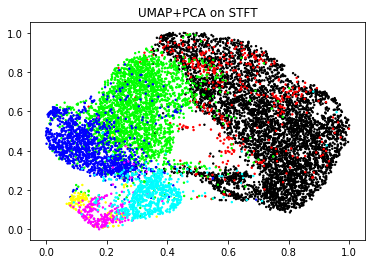

metric		 score
___________________________________
Silhouette	0.0927481957841
Roundess 	0.806071793525
Overlap  	0.234117192129
-----------------------------------
Final Score	1.13293718144


In [31]:
 
def printMetrics(scores):
    print('metric\t\t score')
    print('_' * 35)
    print('%-9s\t%s' % ('Silhouette', scores[0]))
    print('%-9s\t%s' % ('Roundess', scores[1]))
    print('%-9s\t%s' % ('Overlap', scores[2]))
    print('-' * 35)
    print('%-9s\t%s' % ('Final Score', scores[3]))

plot2D(umap_embeddings['STFT'][0],colorMap,"UMAP+PCA","STFT")
scores = evalMetrics(umap_embeddings['STFT'][0], y_data)
printMetrics(scores)

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, MultiPolygon, Point

from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, MultiPolygon, Point

def computeSilCoeff(data, cluster_labels):
    silhouette_avg = silhouette_score(data, cluster_labels)
    return silhouette_avg

def clusterGeometryMetrics(drum_points, labels):
    grouped_drum_points = {}
    
    for i in range(len(drum_points)):
        if labels[i] not in grouped_drum_points:
            grouped_drum_points[labels[i]] = list()
        grouped_drum_points[labels[i]].append(drum_points[i])
    
    num_labels = len(grouped_drum_points)
    drum_polygons = {}
    
    for drum in grouped_drum_points:
        points = grouped_drum_points[drum]
        hull = ConvexHull(grouped_drum_points[drum])
        drum_polygons[drum] = Polygon([points[v] for v in hull.vertices])
    
    total_hull = ConvexHull(drum_points)
    total_polygon = Polygon([drum_points[v] for v in total_hull.vertices])
    p = [Point(c) for c in total_polygon.exterior.coords]
    total_diameter = max([p1.distance(p2) for p1 in p for p2 in p])
    
    calc_intersect = lambda i, j: drum_polygons[i].intersection(drum_polygons[j]).area / total_polygon.area
    calc_roundness = lambda poly : 4 * np.pi * poly.area / (poly.length**2)
    calc_distance = lambda i, j: drum_polygons[i].distance(drum_polygons[j]) / total_diameter
    
    #overlap areas between the polygons of the different clusters, normalized by area of total plot polygon
    pairwise_intersect_areas = [[calc_intersect(i,j) for i in range(num_labels)] for j in range(num_labels)]
    
    
    # Distance between nearest points of 2 polygons normalized by "diameter" of total plot polygon
    pairwise_distances = [[calc_distance(i,j) for i in range(num_labels)] for j in range(num_labels)]
    
    #measure of "roundness" of each polygon based on Polsby-Popper Test
    roundness = [calc_roundness(drum_polygons[d]) for d in drum_polygons]
    roundness_np = np.asarray(roundness)
    roundness_mean = np.mean(roundness_np)
    
    #relative sizes of each cluster polygon normalized by area of total plot polygon
    relative_areas = [drum_polygons[d].area / total_polygon.area for d in drum_polygons]
    
   #the polygons themselves for further processing 
    polygons = drum_polygons.values() + [total_polygon]
    
    #the area of the union of all cluser polygons over the area of the total plot
    overlap_ratio = reduce(lambda a,b: a.union(b), polygons[1:], polygons[0]).area / sum([p.area for p in polygons])
    
    returnVal = {}
    returnVal['pairwise_intersect_areas'] = pairwise_intersect_areas
    returnVal['roundness'] = roundness
    returnVal['roundness_mean'] = roundness_mean
    returnVal['relative_areas'] = relative_areas
    returnVal['overlap_ratio'] = overlap_ratio
    returnVal['polygons'] = polygons
    returnVal['pairwise_distances'] = pairwise_distances
    return returnVal

In [15]:
import time
umap_embeddings = {}
umap_embeddings['mfccs'] = []
umap_embeddings['MIR'] = []
umap_embeddings['STFT'] = []
umap_embeddings['Wavenet'] = []

neighbours = [5, 10, 15, 30, 50]
distances = [0.000, 0.001, 0.01, 0.1, 0.5]
for i, neighbour in enumerate(neighbours):
    for j, distance in enumerate(distances):
        start_time = time.time()
        umap_mfccs = get_scaled_umap_embeddings(x_data_MFCC,
                                                neighbour,
                                                distance)
        umap_MIR = get_scaled_umap_embeddings(x_data_MIR,
                                                  neighbour,
                                                  distance)
        umap_STFT = get_scaled_umap_embeddings(x_data_STFT,
                                                  neighbour,
                                                  distance)
        umap_Wavenet = get_scaled_umap_embeddings(x_data_Wavenet,
                                                  neighbour,
                                                  distance)
        
        umap_embeddings['mfccs'].append(umap_mfccs)
        umap_embeddings['MIR'].append(umap_MIR)
        umap_embeddings['STFT'].append(umap_STFT)
        umap_embeddings['Wavenet'].append(umap_Wavenet)
        print("time in secs: ", time.time() - start_time, "neighbour: ",neighbour,"distance: ",distance)

Exception KeyboardInterrupt in <function on_disposal at 0x14406c848> ignored


('time in secs: ', 159.71527910232544, 'neighbour: ', 50, 'distance: ', 0.5)


In [ ]:
# save UMAP embeddings that took so long to compute!
import pickle
with open('./drumEmbeddings/UMAP_embeddings_all.pkl','wb') as f:
    pickle.dump(umap_embeddings, f)

In [41]:
umap_embeddings = pickle.load(open('./drumEmbeddings/UMAP_embeddings_all.pkl','rb'))

In [2]:
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, MultiPolygon, Point

def plotUMAPEmbeddings(embedding, labels):
    neighbours = [5, 10, 15, 30, 50]
    distances = [0.001, 0.01, 0.1, 0.5]
    fig, ax = plt.subplots(nrows=len(neighbours), 
                       ncols=len(distances),
                       figsize=(40, 40))

    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            current_plot = i * len(distances) + j
            col.scatter(embedding[current_plot].T[0], 
                        embedding[current_plot].T[1], 
                        c=colorMap,
                        s=1)
            (silhouette_avg, roundness_mean, overlap_ratio, aggregate) = computeMetrics(embedding[current_plot], labels)
            
            col.set_title("neighbours: " + str(neighbours[i]) + " distances: " + str(distances[j]) + '\n' + 
                         "sil_coeff: " + str(round(silhouette_avg,4)) + 
                          "  roundess: " + str(round(roundness_mean,4)) + '\n' +
                          "overlap: " + str(round(overlap_ratio,4)) + 
                          "  aggregate: " + str(round(aggregate,4)))
   
    plt.show()
    
def computeMetrics(embedding, labels):
    silhouette_avg = computeSilCoeff(embedding,labels)

    geo_metrics = clusterGeometryMetrics(embedding,labels)
    roundness_mean = geo_metrics["roundness_mean"]
    overlap_ratio = geo_metrics["overlap_ratio"]

    aggregate = silhouette_avg + roundness_mean + overlap_ratio
    return (silhouette_avg, roundness_mean, overlap_ratio, aggregate)

def printMetricsUMAP(embeddings, labels):
    neighbours = [5, 10, 15, 30, 50]
    distances = [0.001, 0.01, 0.1, 0.5]
    for i, neighbour in enumerate(neighbours):
        for j, distance in enumerate(distances):
            current_idx = i * len(distances) + j
            silhouette_avg = computeSilCoeff(embeddings[current_idx],labels)
            print(" -- neighbour:", neighbour, "distance:",distance," -- ")
            print("silhouette: ", silhouette_avg)
            
            geo_metrics = clusterGeometryMetrics(embeddings[current_idx],labels)
            roundness_mean = geo_metrics["roundness_mean"]
            overlap_ratio = geo_metrics["overlap_ratio"]
            print("roundness_mean", roundness_mean)
            print("overlap_ratio", overlap_ratio)
            
            aggregate = silhouette_avg + roundness_mean + overlap_ratio
            print("aggregate: ", aggregate)

# Plotting UMAP on MIR

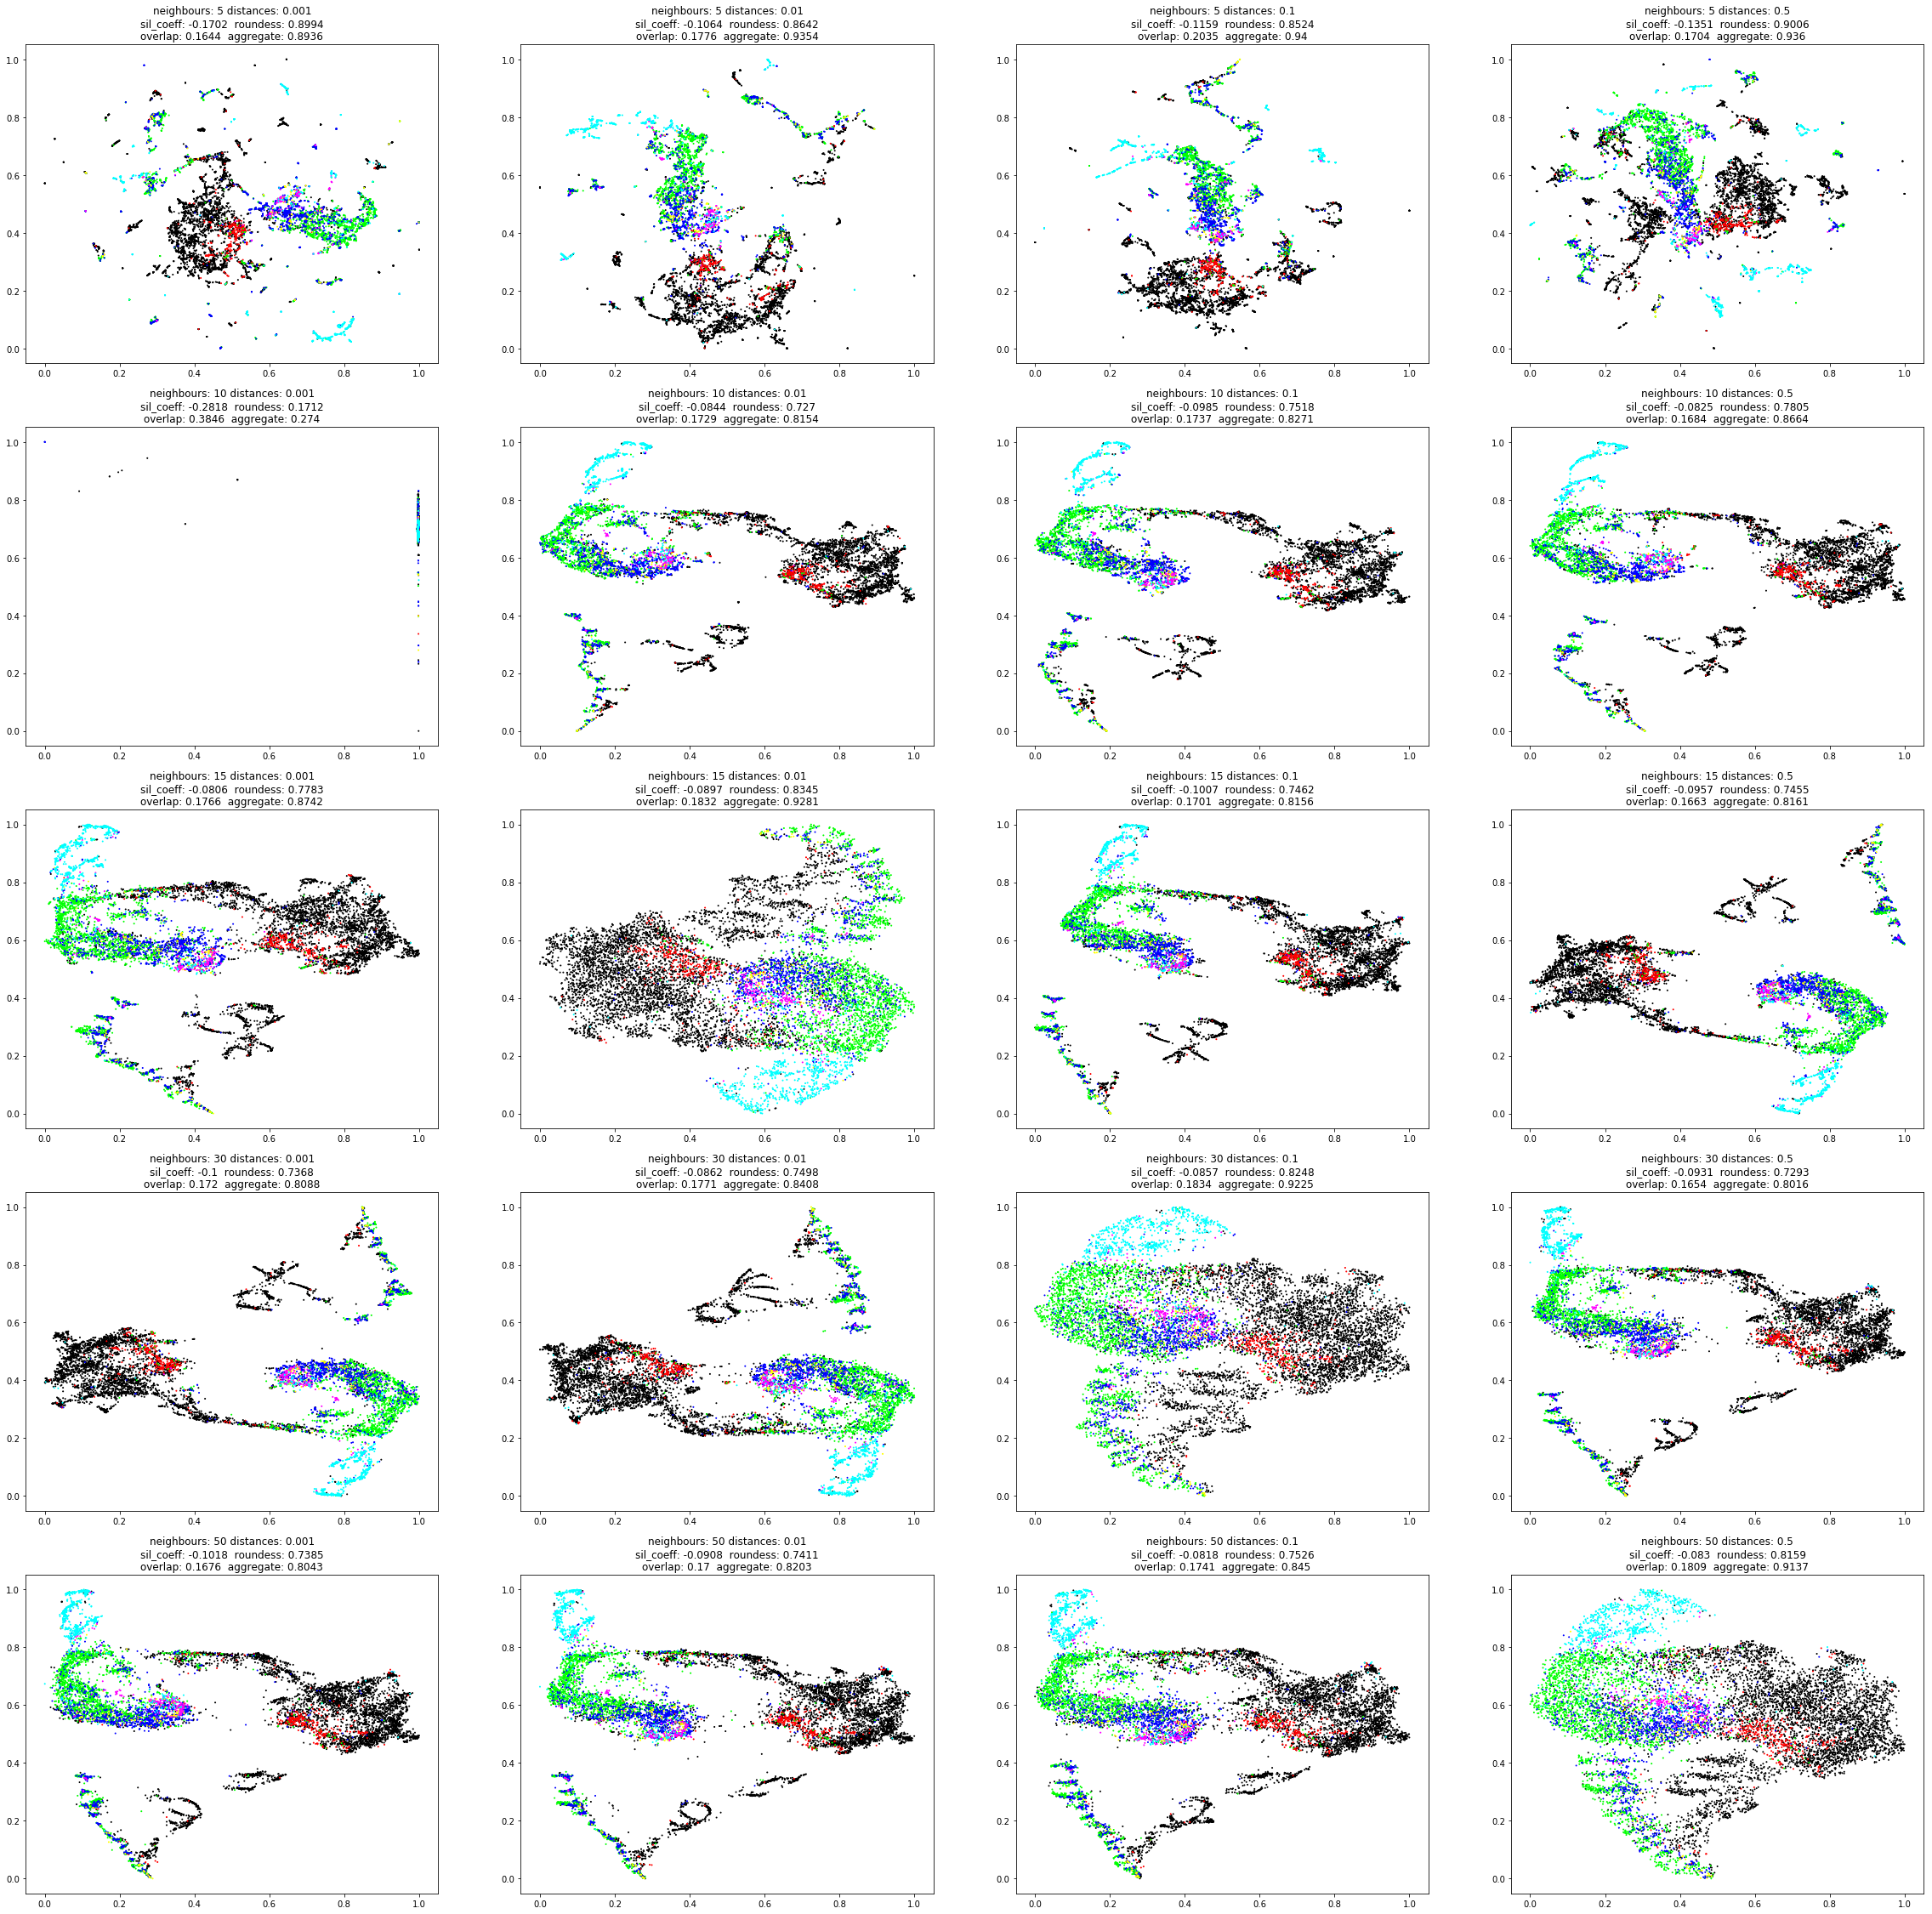

In [53]:
plotUMAPEmbeddings(umap_embeddings['MIR'],y_data)

# Plotting UMAP on STFT

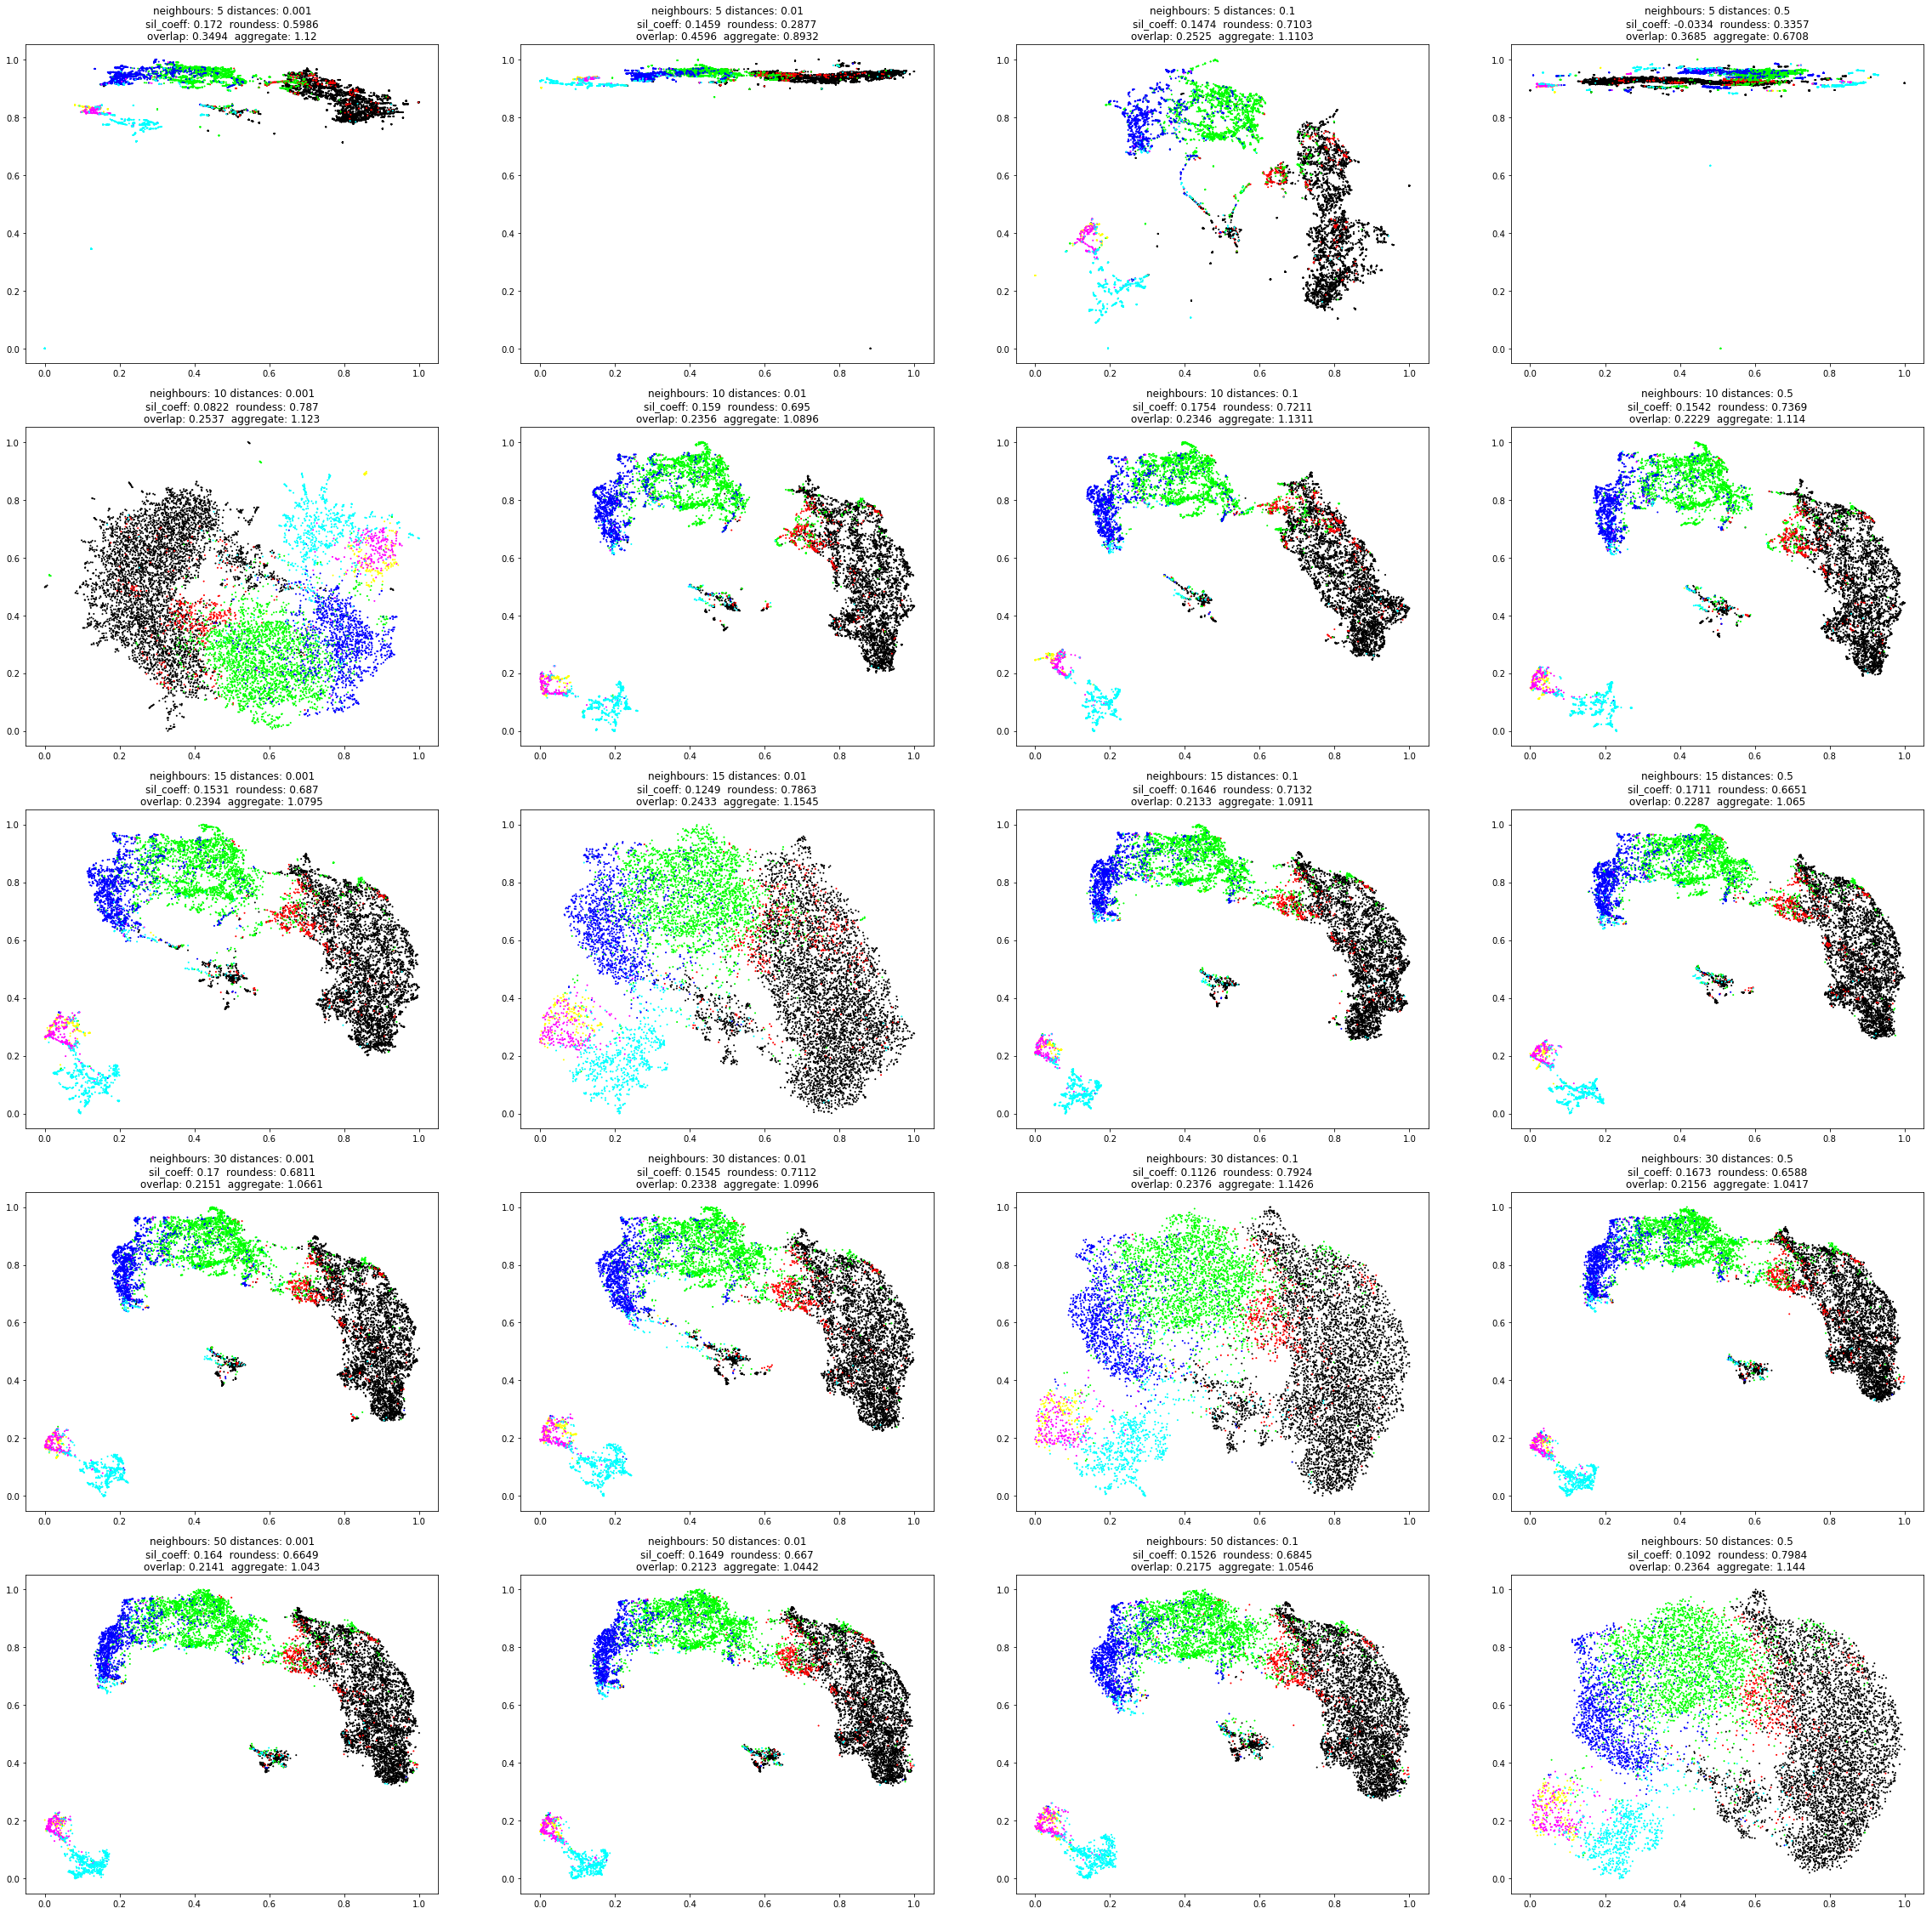

In [54]:
plotUMAPEmbeddings(umap_embeddings['STFT'],y_data)

# Plotting UMAP on MFCC

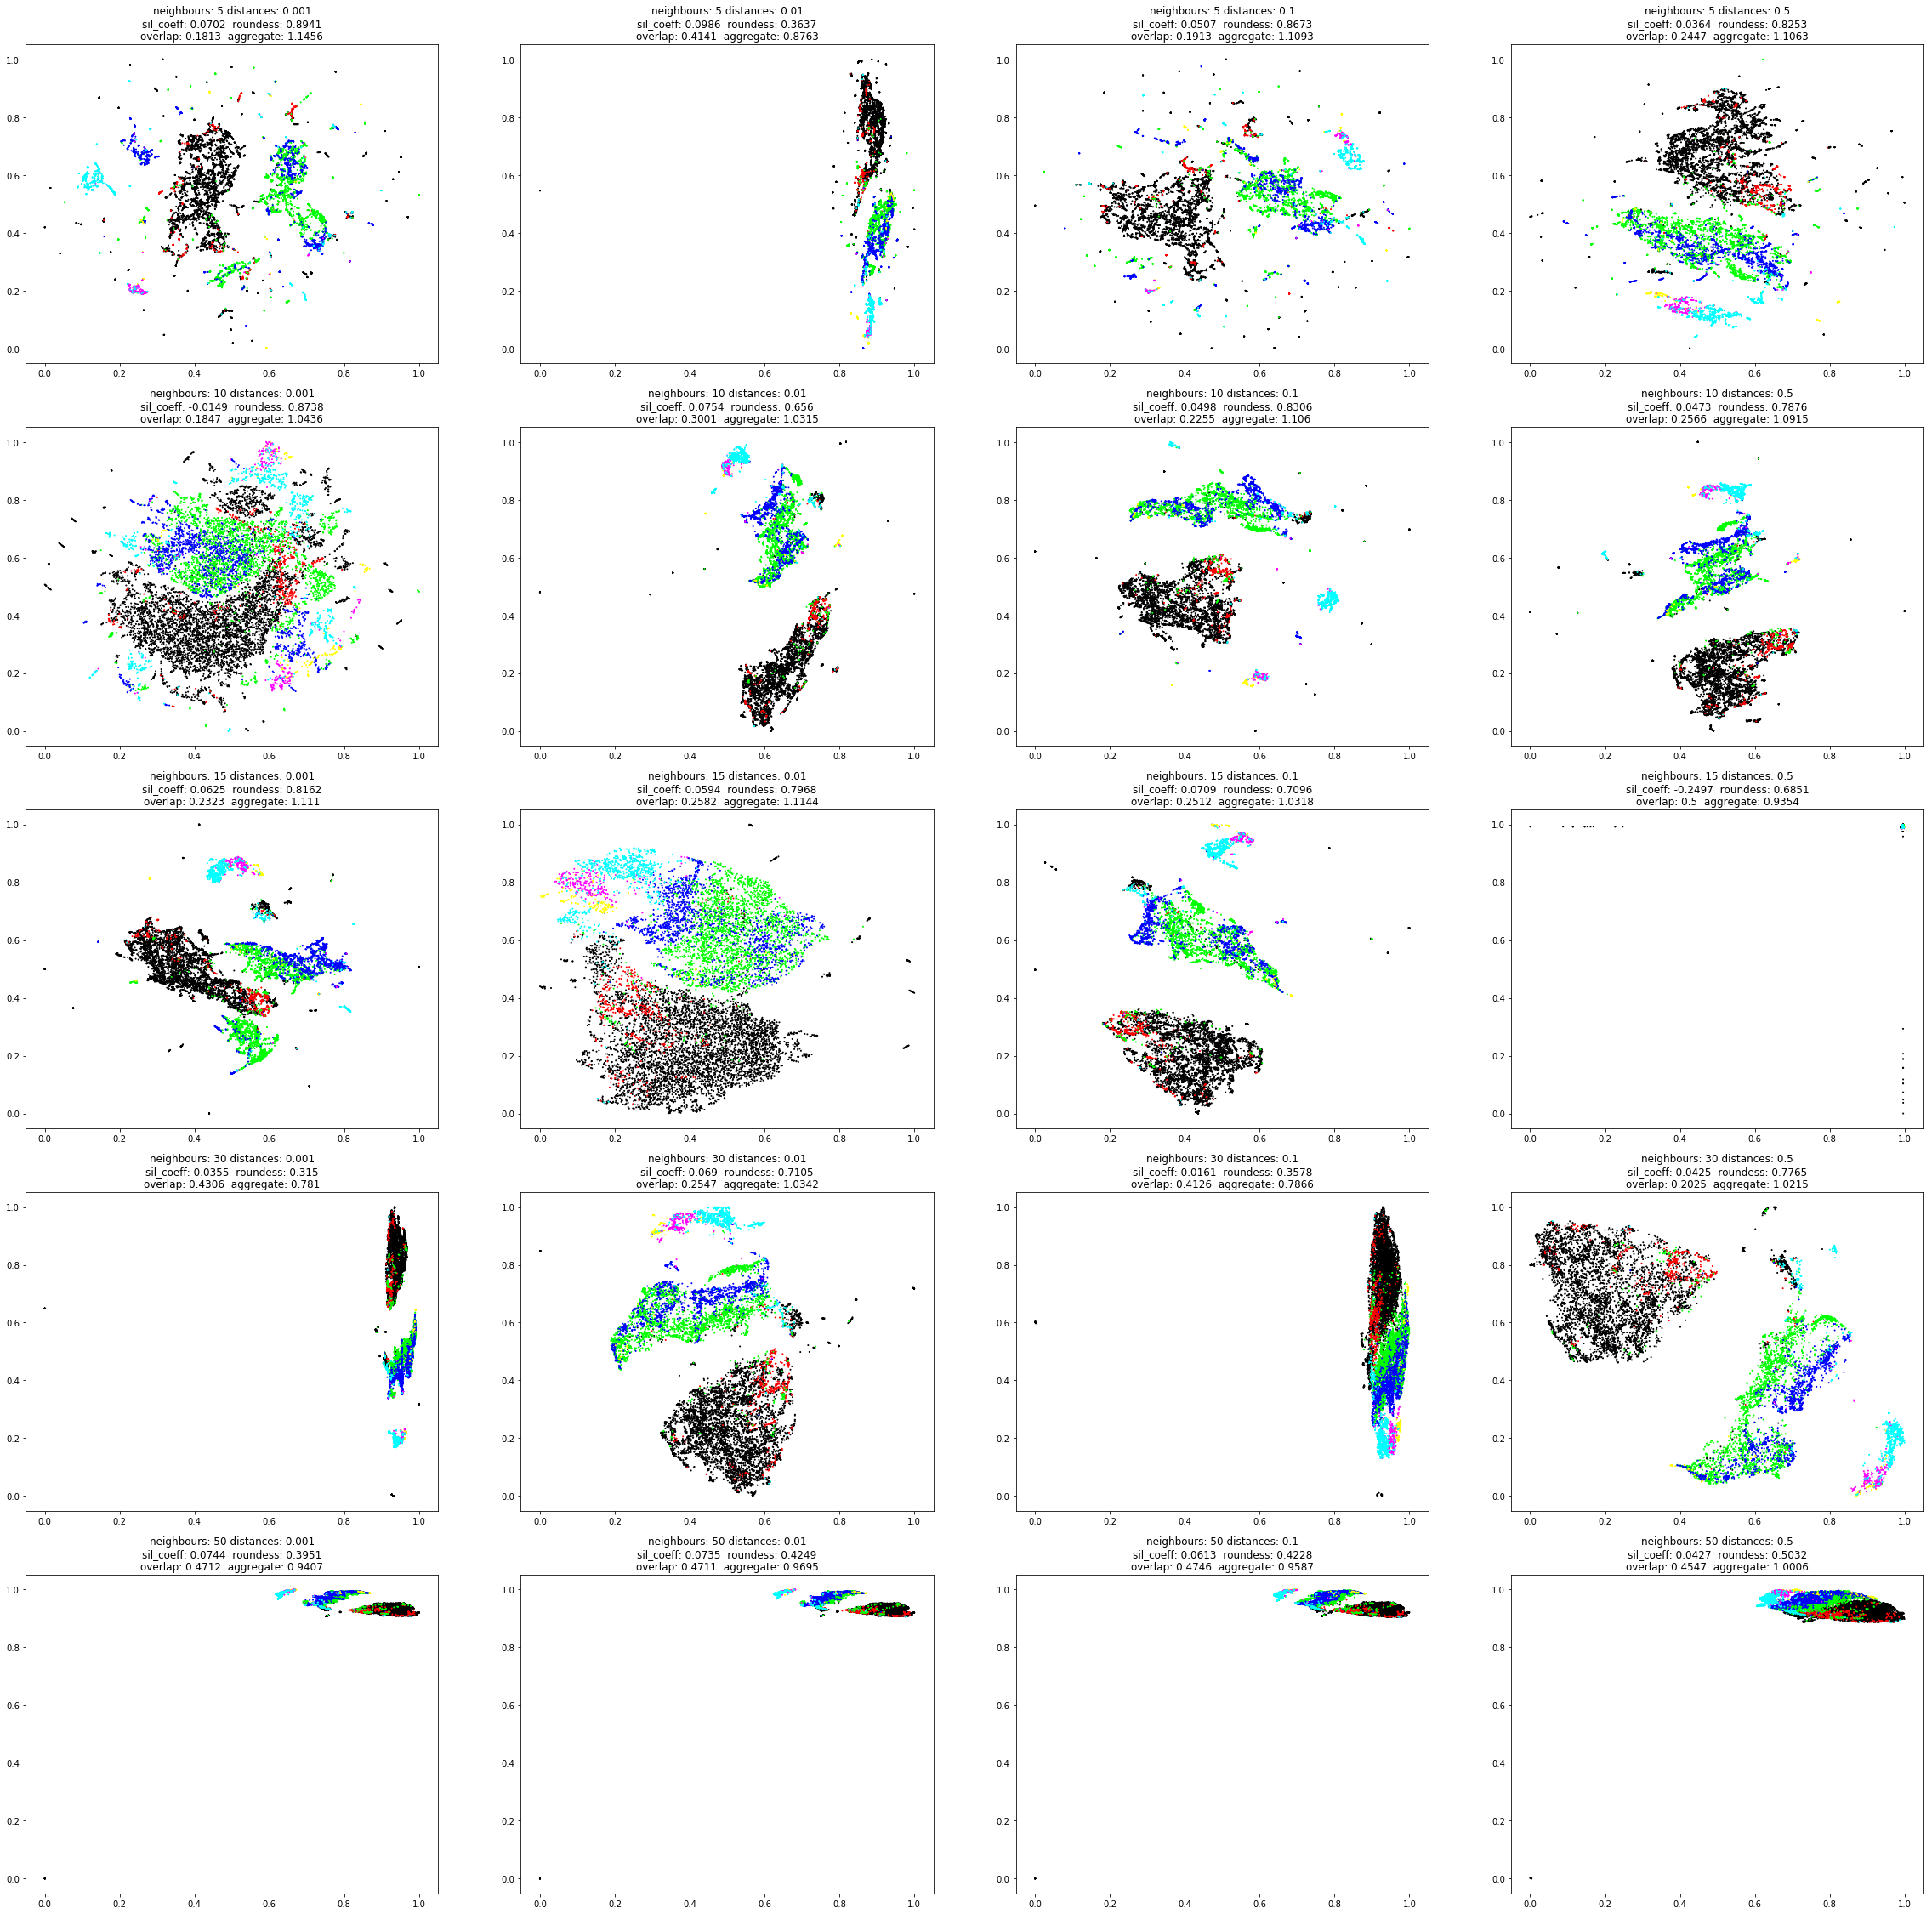

In [57]:
plotUMAPEmbeddings(umap_embeddings['mfccs'],y_data)

# Plotting UMAP on WaveNet

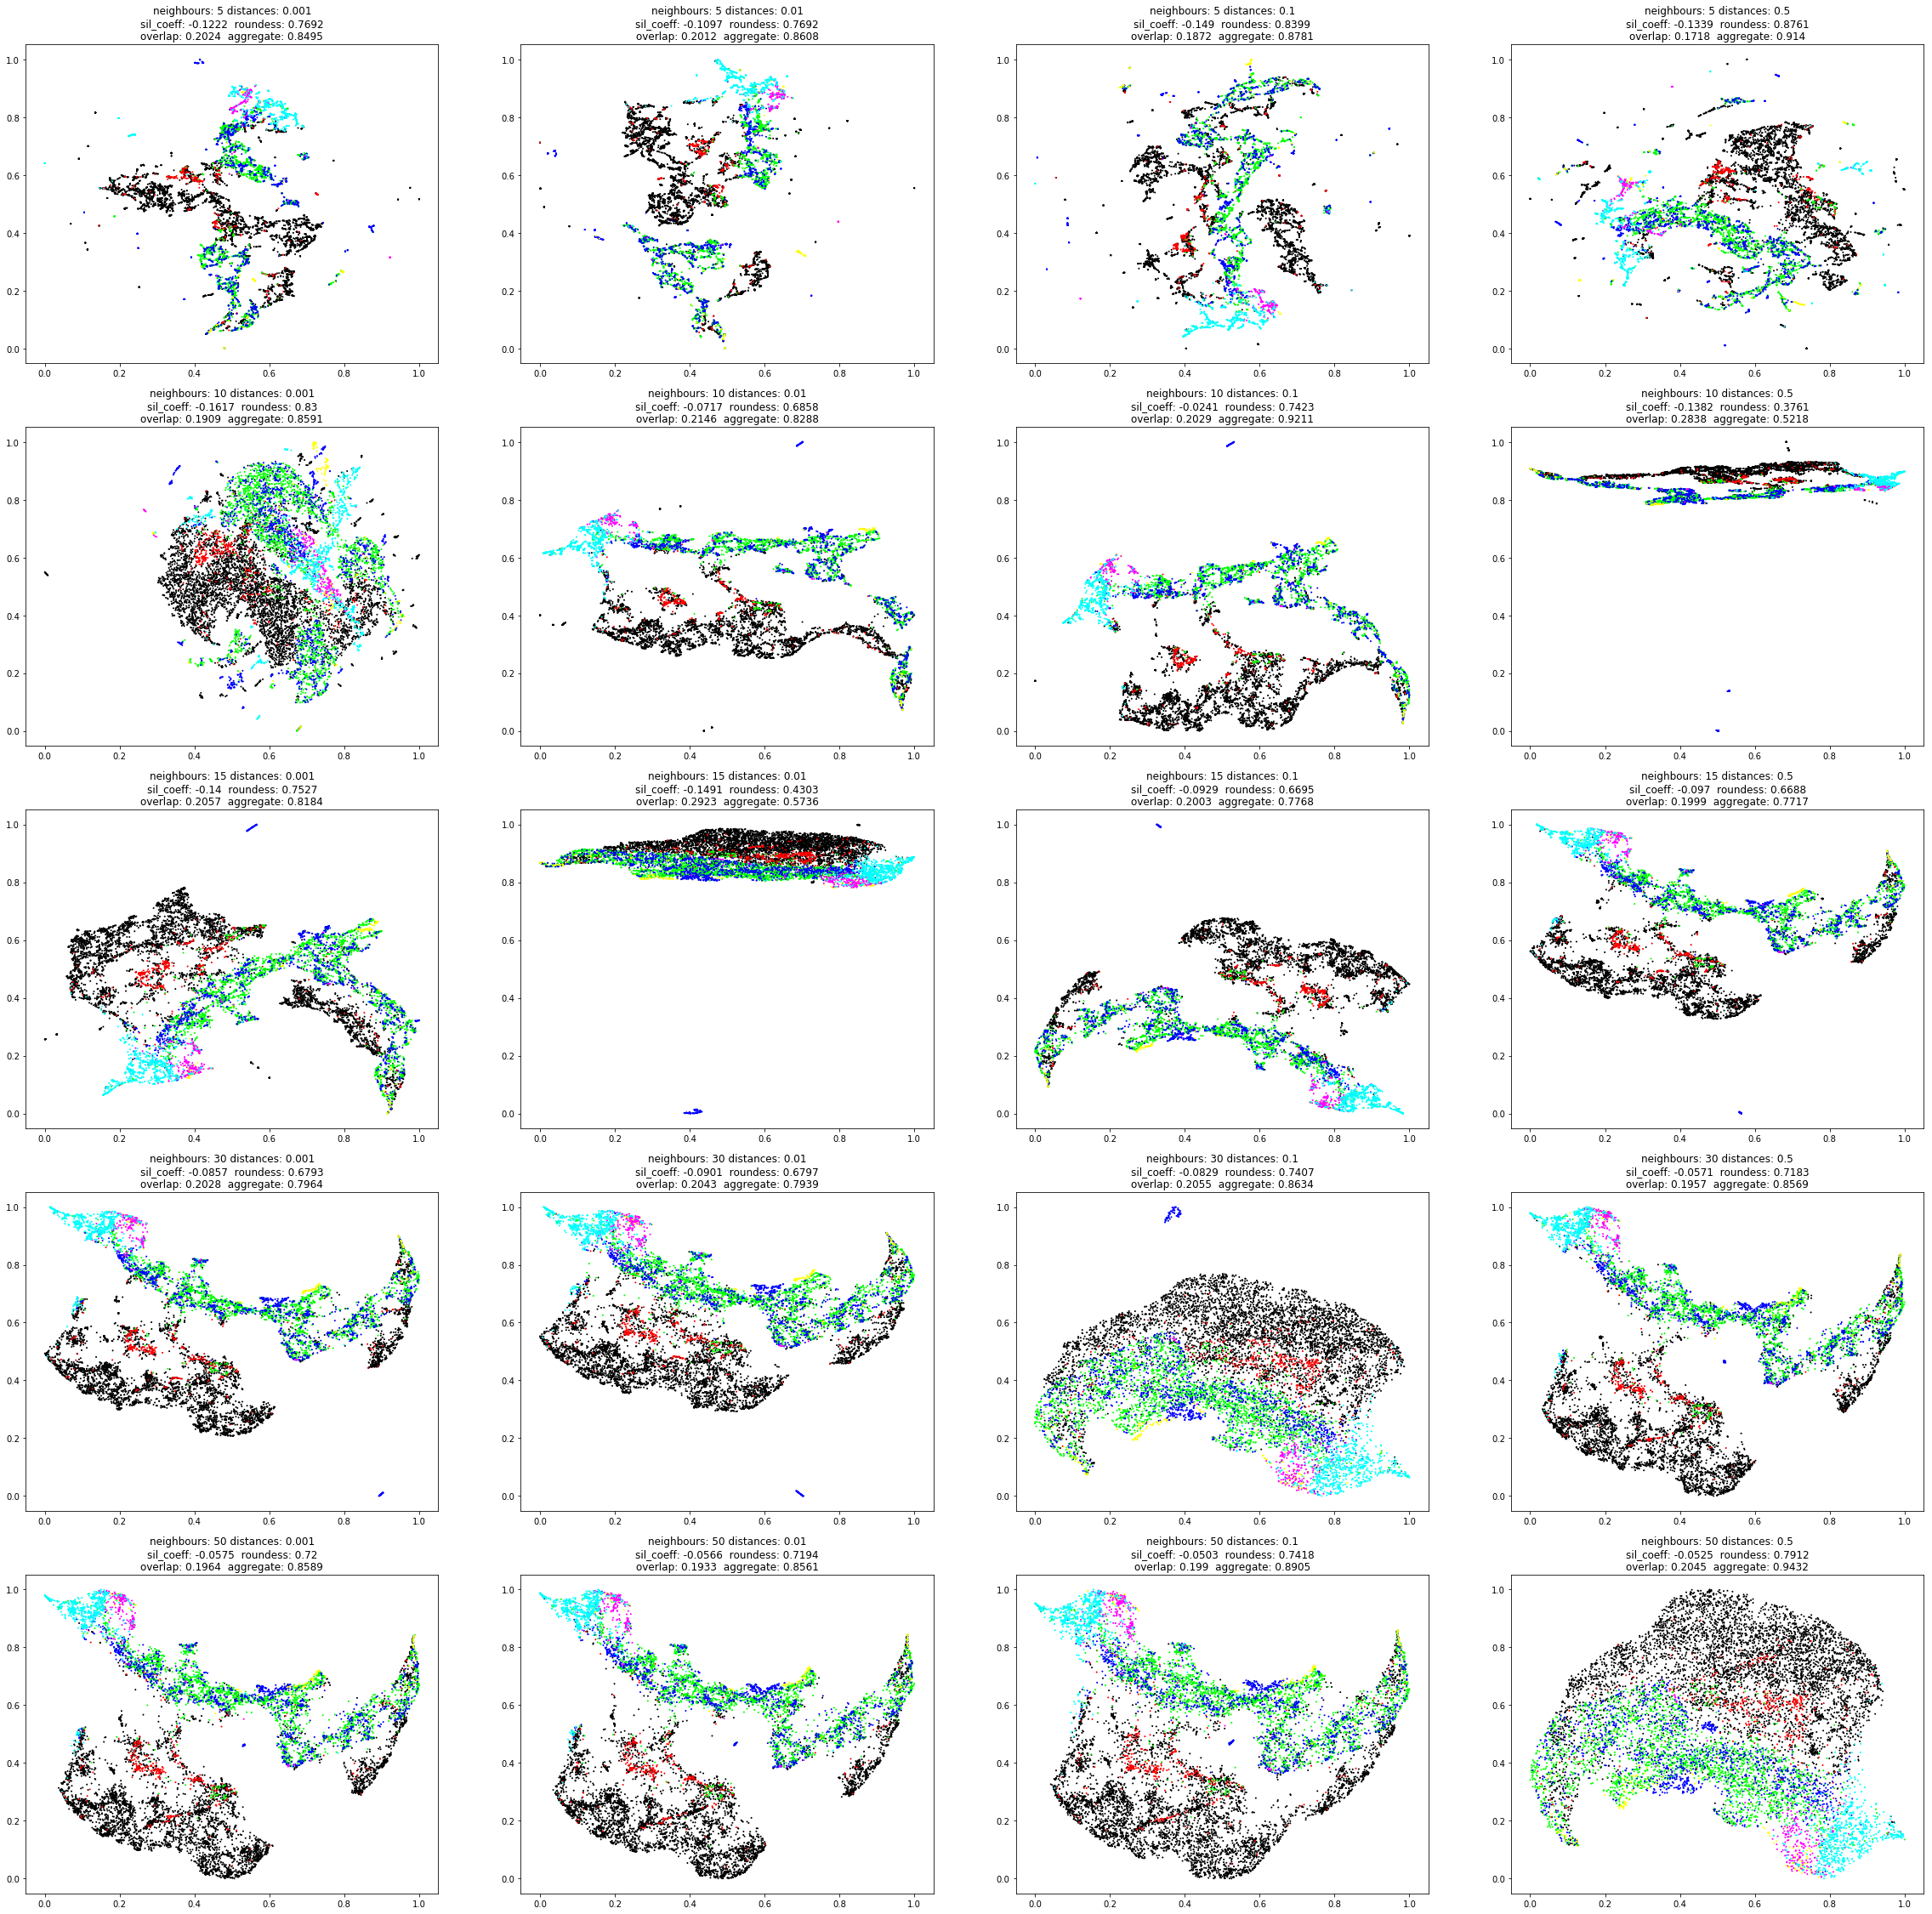

In [58]:
plotUMAPEmbeddings(umap_embeddings['Wavenet'],y_data)